# Rational belief updating in chimpanzees

**Inspired by:** Hanna Schleihauf et al., _Chimpanzees rationally revise their beliefs._ Science 390, 521-526(2025). DOI:10.1126/science.adq5229

Experiments 1 and 2: A chimpanzee is given a choice between two boxes, which may or may not contain food. Weak evidence (e.g. noise) is presented for food in one box, and the chimpanzee makes a choice. Then, stronger evidence (e.g. direct visual access) is presented for food in the other box, and the chimpanzee makes a second choice.

(The experiments differ in whether the visual modality provided stronger or weaker evidence than the auditory modality. Weaker evidence was provided by the indirect evidence of crumbs left around the relevant box.)

In [1]:
from memo import memo
import jax.numpy as np
from matplotlib import pyplot as plt
from enum import IntEnum
from jax.scipy.stats.bernoulli import pmf as ber

In [2]:
class Box(IntEnum):
    FST_BOX = 0
    SND_BOX = 1

class FoodStatus(IntEnum):
    EMPTY_BOX = 0
    FOODY_BOX = 1

class EvidenceType(IntEnum):
    CRUMBS = 0
    NOISES = 1
    VISUAL = 2

def p_evidence(et, fs):
    # Probability of "foody" evidence given evidence type and food status
    return np.array([
        # crumbs
        [0.5, 0.6],  # very weak evidence
        # noises
        [0.3, 0.6],  # moderately weak evidence
        # visual
        [0.01, 0.9]   # strong evidence
    ])[et, fs]

A rational model predicts that on its first choice, the subject will prefer the box for which evidence has been given.

In [3]:
@memo
def first_choice[et1: EvidenceType, b: Box]():
    chimp: knows(et1)
    chimp: wants(
        get_food=
        (world.box1_fs if b=={Box.FST_BOX} else world.box2_fs) == {FoodStatus.FOODY_BOX}
    )
    chimp: thinks[
        world: chooses(box1_fs in FoodStatus, wpp=1),
        world: chooses(box2_fs in FoodStatus, wpp=1),

        world: knows(et1),
        world: chooses(e1 in FoodStatus, wpp=ber(e1, p_evidence(et1, box1_fs))),
    ]
    chimp: observes_that [world.e1 == {FoodStatus.FOODY_BOX}]
    chimp: chooses(b in Box, wpp=exp(10.0 * EU[get_food]))
    return Pr[chimp.b == b]

Z = first_choice(print_table=True);

+-------------------+---------+-----------------------+
| et1: EvidenceType | b: Box  | first_choice          |
+-------------------+---------+-----------------------+
| CRUMBS            | FST_BOX | 0.6117194294929504    |
| CRUMBS            | SND_BOX | 0.38828057050704956   |
| NOISES            | FST_BOX | 0.8411309123039246    |
| NOISES            | SND_BOX | 0.15886907279491425   |
| VISUAL            | FST_BOX | 0.9925355911254883    |
| VISUAL            | SND_BOX | 0.007464459165930748  |
+-------------------+---------+-----------------------+


Let's reproduce Fig 2A from the paper.

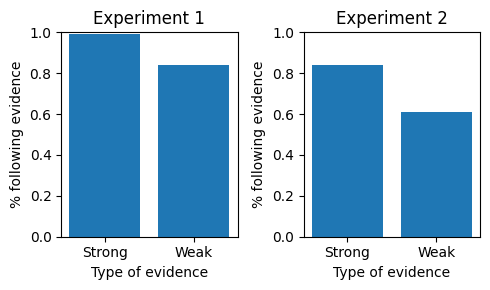

In [4]:
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.title('Experiment 1')
plt.bar([0, 1], [Z[EvidenceType.VISUAL, Box.FST_BOX], Z[EvidenceType.NOISES, Box.FST_BOX]])
plt.xticks([0, 1], ['Strong', 'Weak']);
plt.ylim(0, 1)
plt.xlabel('Type of evidence')
plt.ylabel('% following evidence')

plt.subplot(1, 2, 2)
plt.title('Experiment 2')
plt.bar([0, 1], [Z[EvidenceType.NOISES, Box.FST_BOX], Z[EvidenceType.CRUMBS, Box.FST_BOX]])
plt.xticks([0, 1], ['Strong', 'Weak']);
plt.ylim(0, 1)
plt.xlabel('Type of evidence')
plt.ylabel('% following evidence')

plt.tight_layout()

Our model also predicts a distinct pattern of belief updating upon being given the second piece of evidence. The subject's choice flips if and only if the second piece of evidence is stronger.

In [5]:
@memo
def second_choice[et1: EvidenceType, et2: EvidenceType, b: Box]():
    chimp: knows(et1, et2)
    chimp: wants(
        get_food=
        (world.box1_fs if b=={Box.FST_BOX} else world.box2_fs) == {FoodStatus.FOODY_BOX}
    )
    chimp: thinks[
        world: chooses(box1_fs in FoodStatus, wpp=1),
        world: chooses(box2_fs in FoodStatus, wpp=1),

        world: knows(et1, et2),
        world: chooses(e1 in FoodStatus, wpp=ber(e1, p_evidence(et1, box1_fs))),
        world: chooses(e2 in FoodStatus, wpp=ber(e2, p_evidence(et2, box2_fs)))
    ]
    chimp: observes_that [world.e1 == {FoodStatus.FOODY_BOX}]
    chimp: observes_that [world.e2 == {FoodStatus.FOODY_BOX}]
    chimp: chooses(b in Box, wpp=exp(10.0 * EU[get_food]))
    return Pr[chimp.b == b]

Z = second_choice(print_table=True);

+-------------------+-------------------+---------+-----------------------+
| et1: EvidenceType | et2: EvidenceType | b: Box  | second_choice         |
+-------------------+-------------------+---------+-----------------------+
| CRUMBS            | CRUMBS            | FST_BOX | 0.5                   |
| CRUMBS            | CRUMBS            | SND_BOX | 0.5                   |
| CRUMBS            | NOISES            | FST_BOX | 0.22932583093643188   |
| CRUMBS            | NOISES            | SND_BOX | 0.7706741690635681    |
| CRUMBS            | VISUAL            | FST_BOX | 0.011709635145962238  |
| CRUMBS            | VISUAL            | SND_BOX | 0.9882904291152954    |
| NOISES            | CRUMBS            | FST_BOX | 0.7706740498542786    |
| NOISES            | CRUMBS            | SND_BOX | 0.22932595014572144   |
| NOISES            | NOISES            | FST_BOX | 0.5                   |
| NOISES            | NOISES            | SND_BOX | 0.5                   |
| NOISES    

Now, let's reproduce Figure 2B with our model predictions.

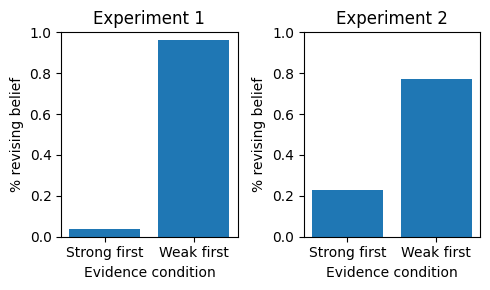

In [6]:
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.title('Experiment 1')
plt.bar(
    [0, 1],
    [
        Z[EvidenceType.VISUAL, EvidenceType.NOISES, Box.SND_BOX],
        Z[EvidenceType.NOISES, EvidenceType.VISUAL, Box.SND_BOX]
    ]
)
plt.xticks([0, 1], ['Strong first', 'Weak first']);
plt.ylim(0, 1)
plt.xlabel('Evidence condition')
plt.ylabel('% revising belief')

plt.subplot(1, 2, 2)
plt.title('Experiment 2')
plt.bar(
    [0, 1],
    [
        Z[EvidenceType.NOISES, EvidenceType.CRUMBS, Box.SND_BOX],
        Z[EvidenceType.CRUMBS, EvidenceType.NOISES, Box.SND_BOX]
    ]
)
plt.xticks([0, 1], ['Strong first', 'Weak first']);
plt.ylim(0, 1)
plt.xlabel('Evidence condition')
plt.ylabel('% revising belief')

plt.tight_layout()